In [1]:
import pickle 
import requests  
import json
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('word_dic/bad_words.txt', 'r') as f:
    bad_words = f.readlines()
    bad_words = [w.strip() for w in bad_words]

with open('word_dic/good_words.txt', 'r') as f:
    good_words = f.readlines()
    good_words = [w.strip() for w in good_words]
    

with open('../yahoo_movie/contents_5001_7242.pickle', 'rb') as handle:
    contents_5001_7242 = pickle.load(handle)
with open('../yahoo_movie/contents_2501_5001.pickle', 'rb') as handle:
    contents_2501_5001 = pickle.load(handle)
with open('../yahoo_movie/contents_1_2501.pickle', 'rb') as handle:
    contents_1_2501 = pickle.load(handle)
    
yahoomovie = contents_1_2501 + contents_2501_5001 + contents_5001_7242
print (len(yahoomovie))

7241


In [3]:
def error_imdb(allcontents):
    contents = []
    error = 0
    for a in allcontents:
        if "error" in a:
            error+=1
        else:
            contents.append(a)
    print "error : {}".format(error)
    d = {}
    for a in contents:
        if a['IMDb'] != None:
            d[a['name_zh']] = a['IMDb']
    return d

def parse_title(title):
    try:
        tmp_title = re.search(r"\[(.*?)\]", title).group().encode('utf8')
        if '雷' in tmp_title:
            if tmp_title in good_words:
                return 'g'
            if tmp_title in bad_words:
                return 'b'
            else:
                return 'n'
    except:
        return None

In [4]:
len(yahoomovie)

7241

In [5]:
noerror_imdb_yahoomovie = error_imdb(yahoomovie)

error : 1076


In [6]:
len(noerror_imdb_yahoomovie)

3137

In [93]:
def score(results):
    
#     uri_search = 'http://teadaiegpu1.hopto.org:9200/pttmovie/_search'
#     results = search(uri_search, search_text)
#     results = results['hits']['hits']
    
    titles = [v['_source']['article_title'] for v in results]
    message_conut = [v['_source']['message_conut'] for v in results]

    # {u'all': 12, u'boo': 1, u'count': 8, u'neutral': 2, u'push': 9}
    g_content = []
    b_content = []
    n_content = []
    for t, message in zip(titles, message_conut):
        sign = parse_title(t)
        if sign == 'g':
            g_content.append(message)
        elif sign == 'b':
            b_content.append(message)
        elif sign == 'n':
            n_content.append(message)
    n = len(g_content) + len(b_content) + len(n_content)
    print '修正前 g: {}, b: {}, n: {} '.format(len(g_content),len(b_content),len(n_content))
    verfify_g_content = []
    verfify_b_content = []
    g2b = 0
    g2n = 0
    for a in  g_content:
        if a['boo'] > a['push']:
            verfify_b_content.append(a)
            g2b+=1
        elif a['boo'] == a['push']:
            n_content.append(a)
            g2n+=1
        else:
            verfify_g_content.append(a)
    b2g = 0
    b2n = 0
    for a in b_content:
        if a['boo'] > a['push']:
            verfify_g_content.append(a)
            b2g+=1
        elif a['boo'] == a['push']:
            n_content.append(a)
            b2n+=1
        else:
            verfify_b_content.append(a)
    verfify_n = len(verfify_g_content) + len(verfify_b_content) + len(n_content)
    print '修正後 g: {}, b: {}, n: {} '.format(len(verfify_g_content),len(verfify_b_content),len(n_content))
#     for t in titles:
#         print t
    print "g2b : {}, g2n : {}, b2g : {}, b2n : {}".format(g2b,g2n,b2g,b2n)
    return g2b, g2n, b2g, b2n,len(verfify_g_content)/float(verfify_n+1)

In [94]:
def search_term(search_text):
    url = 'http://teadaiegpu1.hopto.org:9200/pttmovie/_search'
    query = json.dumps({
        "query": {
            "match_phrase" : {
                "article_title" : search_text
            }
        },
        "size":10000
    })
    response = requests.get(url, data=query)
    results = json.loads(response.text)    
    results = results['hits']['hits']
    return results

In [9]:
yahoomovie_result = []
yahoomovie_keys = []
for movie in noerror_imdb_yahoomovie.keys():
    search_result = search_term(movie)
    if len(search_result) > 10:
        yahoomovie_result.append(search_result)
        yahoomovie_keys.append(movie)

In [10]:
len(yahoomovie_keys)

839

In [100]:
from operator import add

In [106]:
gb = map(add, g2b_l, g2n_l)
bg = map(add, b2g_l, b2n_l)

In [117]:
tmp1 = []
for k, a in zip(keyy, gb):
    tmp1.append((k,a))

tmp2 = []
for k, a in zip(keyy, bg):
    tmp2.append((k,a))

In [128]:
sorted_by_tmp2 = sorted(tmp2, key=lambda tup: tup[1], reverse=True)
print "壞雷轉好雷"
for a in sorted_by_tmp2[:20]:
    print "movie : {}, s : {}".format(a[0], a[1])

壞雷轉好雷
movie : 星際效應, s : 22
movie : 屍速列車, s : 18
movie : 神力女超人, s : 17
movie : 你的名字, s : 12
movie : 愛, s : 12
movie : 移動迷宮, s : 10
movie : 美國隊長, s : 10
movie : 哥吉拉, s : 10
movie : 少女, s : 9
movie : 鋼鐵英雄, s : 9
movie : 亂, s : 8
movie : 超人：鋼鐵英雄, s : 8
movie : 環太平洋, s : 8
movie : 鋼鐵人, s : 7
movie : 地心引力, s : 6
movie : 金牌特務, s : 6
movie : 樓下的房客, s : 6
movie : ID4星際重生, s : 6
movie : 露西, s : 5
movie : 會計師, s : 5


In [122]:
sorted_by_tmp1 = sorted(tmp1, key=lambda tup: tup[1], reverse=True)

In [129]:
print "好雷轉壞雷"
for a in sorted_by_tmp1[:20]:
    print "movie : {}, s : {}".format(a[0], a[1])

好雷轉壞雷
movie : 愛, s : 157
movie : 光, s : 36
movie : 星際效應, s : 18
movie : 美國隊長, s : 13
movie : 鋼鐵人, s : 13
movie : 怒, s : 12
movie : 你的名字, s : 12
movie : 少女, s : 12
movie : 鳥人, s : 12
movie : 屍速列車, s : 12
movie : 鋼鐵英雄, s : 9
movie : 鋼鐵人3, s : 9
movie : 絕地救援, s : 8
movie : 敦克爾克大行動, s : 8
movie : 環太平洋, s : 8
movie : 亂, s : 7
movie : 露西, s : 7
movie : 等一個人咖啡, s : 7
movie : 會計師, s : 6
movie : 佈局, s : 6


In [101]:
print map(add, g2b_l, g2n_l).index(max(map(add, g2b_l, g2n_l)))

530


In [102]:
print map(add, b2g_l, b2n_l).index(max(map(add, b2g_l, b2n_l)))

186


In [104]:
print keyy[530]

愛


In [105]:
print keyy[186]

星際效應


In [131]:
for a in keyy:
    if a == '愛':
        print a
#     print a

愛


In [95]:
keyy = []
imdb = []
pttscore = []
g2b_l = []
g2n_l = []
b2g_l = []
b2n_l = []
for k, v in zip(yahoomovie_keys, yahoomovie_result):
    print k
    keyy.append(k)
    imdb.append(float(noerror_imdb_yahoomovie[k]))
    g2b, g2n, b2g, b2n, s = score(v)
    g2b_l.append(g2b)
    g2n_l.append(g2n)
    b2g_l.append(b2g)
    b2n_l.append(b2n)
    pttscore.append(s)

猩球崛起
修正前 g: 80, b: 21, n: 46 
修正後 g: 76, b: 21, n: 50 
g2b : 1, g2n : 4, b2g : 1, b2n : 0
顛倒世界
修正前 g: 1, b: 0, n: 0 
修正後 g: 1, b: 0, n: 0 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
300壯士：帝國崛起
修正前 g: 10, b: 4, n: 9 
修正後 g: 10, b: 4, n: 9 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
STAR WARS：原力覺醒
修正前 g: 6, b: 0, n: 3 
修正後 g: 6, b: 0, n: 3 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
麻辣嬌鋒
修正前 g: 14, b: 0, n: 6 
修正後 g: 14, b: 0, n: 6 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
正宗哥吉拉
修正前 g: 50, b: 2, n: 14 
修正後 g: 50, b: 2, n: 14 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
獨家腥聞
修正前 g: 20, b: 0, n: 4 
修正後 g: 19, b: 0, n: 5 
g2b : 0, g2n : 1, b2g : 0, b2n : 0
刺客教條
修正前 g: 25, b: 29, n: 25 
修正後 g: 24, b: 29, n: 26 
g2b : 3, g2n : 1, b2g : 3, b2n : 0
遲來的守護者
修正前 g: 11, b: 0, n: 2 
修正後 g: 9, b: 0, n: 4 
g2b : 0, g2n : 2, b2g : 0, b2n : 0
舞力全開
修正前 g: 5, b: 5, n: 7 
修正後 g: 4, b: 5, n: 8 
g2b : 0, g2n : 1, b2g : 0, b2n : 0
非法999
修正前 g: 0, b: 1, n: 2 
修正後 g: 0, b: 1, n: 2 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
神偷奶爸3
修正前 g: 5, b: 2, n: 3 
修正後 g

g2b : 0, g2n : 0, b2g : 0, b2n : 0
逐夢大道
修正前 g: 7, b: 0, n: 1 
修正後 g: 7, b: 0, n: 1 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
謊言的烙印
修正前 g: 14, b: 0, n: 2 
修正後 g: 14, b: 0, n: 2 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
一路順風
修正前 g: 11, b: 3, n: 2 
修正後 g: 9, b: 2, n: 5 
g2b : 0, g2n : 2, b2g : 0, b2n : 1
當他們認真編織時
修正前 g: 20, b: 0, n: 1 
修正後 g: 19, b: 0, n: 2 
g2b : 0, g2n : 1, b2g : 0, b2n : 0
跨界失控
修正前 g: 2, b: 2, n: 6 
修正後 g: 2, b: 1, n: 7 
g2b : 0, g2n : 0, b2g : 0, b2n : 1
BJ有喜
修正前 g: 12, b: 1, n: 2 
修正後 g: 11, b: 1, n: 3 
g2b : 0, g2n : 1, b2g : 0, b2n : 0
驗屍官
修正前 g: 16, b: 1, n: 11 
修正後 g: 17, b: 0, n: 11 
g2b : 0, g2n : 0, b2g : 1, b2n : 0
愛國者行動
修正前 g: 12, b: 1, n: 4 
修正後 g: 11, b: 1, n: 5 
g2b : 0, g2n : 1, b2g : 0, b2n : 0
屍變
修正前 g: 23, b: 0, n: 5 
修正後 g: 22, b: 0, n: 6 
g2b : 0, g2n : 1, b2g : 0, b2n : 0
變形金剛5：最終騎士
修正前 g: 2, b: 5, n: 7 
修正後 g: 2, b: 5, n: 7 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
同盟鶼鰈
修正前 g: 10, b: 0, n: 13 
修正後 g: 10, b: 0, n: 13 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
聖獄：耶路撒冷
修正前 g

一代宗師
修正前 g: 18, b: 14, n: 9 
修正後 g: 18, b: 14, n: 9 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
麻辣賤諜
修正前 g: 15, b: 2, n: 7 
修正後 g: 15, b: 2, n: 7 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
肌膚之侵
修正前 g: 9, b: 0, n: 4 
修正後 g: 8, b: 0, n: 5 
g2b : 0, g2n : 1, b2g : 0, b2n : 0
一個勺子
修正前 g: 7, b: 0, n: 0 
修正後 g: 7, b: 0, n: 0 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
安娜貝爾：造孽
修正前 g: 11, b: 3, n: 7 
修正後 g: 12, b: 2, n: 7 
g2b : 0, g2n : 0, b2g : 1, b2n : 0
青春倒退嚕
修正前 g: 8, b: 0, n: 5 
修正後 g: 6, b: 0, n: 7 
g2b : 0, g2n : 2, b2g : 0, b2n : 0
怪奇孤兒院
修正前 g: 27, b: 7, n: 16 
修正後 g: 26, b: 6, n: 18 
g2b : 0, g2n : 1, b2g : 0, b2n : 1
守護者聯盟
修正前 g: 0, b: 11, n: 8 
修正後 g: 0, b: 11, n: 8 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
殺人犯
修正前 g: 7, b: 1, n: 3 
修正後 g: 7, b: 1, n: 3 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
星光大盜
修正前 g: 4, b: 2, n: 3 
修正後 g: 3, b: 2, n: 4 
g2b : 0, g2n : 1, b2g : 0, b2n : 0
海灘救護隊
修正前 g: 7, b: 2, n: 2 
修正後 g: 7, b: 2, n: 2 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
奇異博士
修正前 g: 68, b: 12, n: 39 
修正後 g: 71, b: 9, n: 39 
g2

修正前 g: 17, b: 3, n: 17 
修正後 g: 15, b: 3, n: 19 
g2b : 0, g2n : 2, b2g : 0, b2n : 0
寵物當家
修正前 g: 4, b: 3, n: 16 
修正後 g: 4, b: 2, n: 17 
g2b : 0, g2n : 1, b2g : 1, b2n : 0
反擊
修正前 g: 8, b: 2, n: 4 
修正後 g: 7, b: 1, n: 6 
g2b : 0, g2n : 1, b2g : 0, b2n : 1
八月三十一日，我在奧斯陸
修正前 g: 9, b: 0, n: 0 
修正後 g: 8, b: 0, n: 1 
g2b : 0, g2n : 1, b2g : 0, b2n : 0
蟻人
修正前 g: 63, b: 9, n: 18 
修正後 g: 61, b: 11, n: 18 
g2b : 3, g2n : 0, b2g : 1, b2n : 0
特攻聯盟2
修正前 g: 20, b: 2, n: 15 
修正後 g: 20, b: 2, n: 15 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
牯嶺街少年殺人事件
修正前 g: 3, b: 0, n: 2 
修正後 g: 3, b: 0, n: 2 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
郊遊
修正前 g: 8, b: 0, n: 3 
修正後 g: 7, b: 0, n: 4 
g2b : 0, g2n : 1, b2g : 0, b2n : 0
末日列車
修正前 g: 21, b: 7, n: 3 
修正後 g: 22, b: 6, n: 3 
g2b : 0, g2n : 0, b2g : 1, b2n : 0
巴黎野玫瑰
修正前 g: 9, b: 0, n: 1 
修正後 g: 9, b: 0, n: 1 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
送子鳥
修正前 g: 8, b: 0, n: 2 
修正後 g: 8, b: 0, n: 2 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
海底總動員2：多莉去哪兒？
修正前 g: 9, b: 0, n: 2 
修正後 g: 9, b: 0, n: 2

g2b : 1, g2n : 7, b2g : 1, b2n : 0
夜行人生
修正前 g: 4, b: 3, n: 5 
修正後 g: 5, b: 2, n: 5 
g2b : 0, g2n : 0, b2g : 1, b2n : 0
春嬌救志明
修正前 g: 10, b: 0, n: 12 
修正後 g: 9, b: 0, n: 13 
g2b : 0, g2n : 1, b2g : 0, b2n : 0
復仇者聯盟
修正前 g: 69, b: 29, n: 84 
修正後 g: 69, b: 27, n: 86 
g2b : 1, g2n : 2, b2g : 3, b2n : 0
侏羅紀世界
修正前 g: 47, b: 7, n: 38 
修正後 g: 45, b: 7, n: 40 
g2b : 3, g2n : 2, b2g : 3, b2n : 0
潘恩：航向夢幻島
修正前 g: 4, b: 3, n: 8 
修正後 g: 4, b: 3, n: 8 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
親愛媽咪
修正前 g: 18, b: 0, n: 0 
修正後 g: 15, b: 1, n: 2 
g2b : 1, g2n : 2, b2g : 0, b2n : 0
比利林恩的中場戰事
修正前 g: 57, b: 3, n: 16 
修正後 g: 57, b: 2, n: 17 
g2b : 0, g2n : 1, b2g : 1, b2n : 0
天機：富春山居圖
修正前 g: 5, b: 6, n: 13 
修正後 g: 5, b: 6, n: 13 
g2b : 0, g2n : 0, b2g : 0, b2n : 0
驚爆焦點
修正前 g: 50, b: 0, n: 5 
修正後 g: 47, b: 0, n: 8 
g2b : 0, g2n : 3, b2g : 0, b2n : 0
暫時停止呼吸
修正前 g: 24, b: 6, n: 7 
修正後 g: 25, b: 5, n: 7 
g2b : 0, g2n : 0, b2g : 1, b2n : 0
風暴
修正前 g: 80, b: 13, n: 47 
修正後 g: 76, b: 10, n: 54 
g2b : 0, g2n : 5, b2g : 1, b2

In [22]:
for aa, a,b in zip(keyy, imdb, pttscore):
    print "movie: {}, imdb: {}, ptt: {:.2f}".format(aa,a,b)

movie: 猩球崛起, imdb: 7.6, ptt: 0.51
movie: 顛倒世界, imdb: 6.4, ptt: 0.50
movie: 300壯士：帝國崛起, imdb: 6.2, ptt: 0.42
movie: STAR WARS：原力覺醒, imdb: 8.1, ptt: 0.60
movie: 麻辣嬌鋒, imdb: 6.6, ptt: 0.67
movie: 正宗哥吉拉, imdb: 6.8, ptt: 0.75
movie: 獨家腥聞, imdb: 7.9, ptt: 0.76
movie: 刺客教條, imdb: 5.9, ptt: 0.30
movie: 遲來的守護者, imdb: 7.6, ptt: 0.64
movie: 舞力全開, imdb: 6.2, ptt: 0.22
movie: 非法999, imdb: 6.3, ptt: 0.00
movie: 神偷奶爸3, imdb: 6.4, ptt: 0.45
movie: 里約大冒險, imdb: 6.9, ptt: 0.50
movie: 惡棍英雄：死侍, imdb: 8.0, ptt: 0.87
movie: 地心引力, imdb: 7.8, ptt: 0.60
movie: 全面進化, imdb: 6.3, ptt: 0.46
movie: 重返20歲, imdb: 6.7, ptt: 0.76
movie: 十年, imdb: 7.1, ptt: 0.62
movie: 目擊者, imdb: 7.9, ptt: 0.66
movie: 進擊的鼓手, imdb: 8.5, ptt: 0.75
movie: 西遊：降魔篇, imdb: 6.8, ptt: 0.54
movie: 真愛BJ4, imdb: 6.0, ptt: 0.43
movie: 寂寞拍賣師, imdb: 7.8, ptt: 0.70
movie: 內布拉斯加, imdb: 7.7, ptt: 0.67
movie: 刺客聶隱娘, imdb: 6.4, ptt: 0.52
movie: 當辣妹來敲門, imdb: 4.9, ptt: 0.25
movie: 我想念我自己, imdb: 7.5, ptt: 0.68
movie: 厲陰宅, imdb: 7.5, ptt: 0.63
movie: 口白人生, im

In [23]:
term_result = search_term("拆彈少年")
len(term_result)
score(term_result)

修正前 g: 14, b: 0, n: 3 
修正後 g: 13, b: 1, n: 3 
g2b : 1, g2n : 0, b2g : 0, b2n : 0


0.7222222222222222

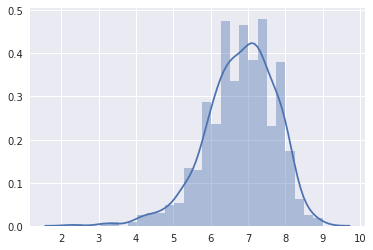

In [27]:
sns.distplot(imdb)

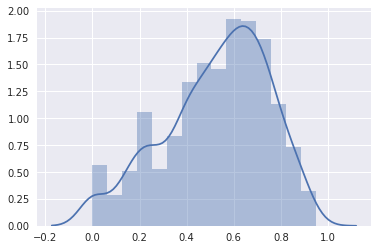

In [42]:
sns.distplot(pttscore)

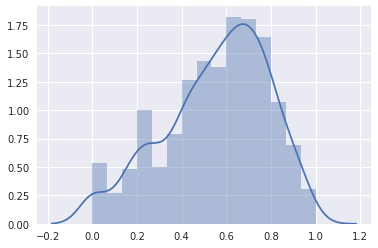

In [38]:
sns.distplot(nor_pttscore)

In [33]:
def nor(l):
    result = []
    l_max = max(l)
    l_min = min(l)
    for a in l:
        result.append((a - l_min) / float((l_max-l_min)))
    return result

In [34]:
nor_pttscore = nor(pttscore)

In [79]:
# year
date_1y = {  "date":
              { "gte": "now-10d-1y",
                "lte": "now-10d"}
             }
# 3months
date_3M = {  "date":
              { "gte": "now-10d-3M",
                "lte": "now-10d"}
             }
# 1month
date_1M = {  "date":
              { "gte": "now-10d-1M",
                "lte": "now-10d"}
             }

# 1week
date_1w = {  "date":
              { "gte": "now-10d-1w",
                "lte": "now-10d"}
             }

# 1d
date_1d = {  "date":
              { "gte": "now-10d-1d",
                "lte": "now-10d"}
             }

def test_search(term):
    url = 'http://teadaiegpu1.hopto.org:9200/pttmovie/_search'
    """Simple Elasticsearch Query"""
    query = json.dumps({
        "_source" : ["date", "article_title", 'author'],
        "query": {
            "bool" : {
                "must" : [
                    {
                        "match_phrase" : {
                            "article_title" : term
                        }                        
                    },
                    {
                        "range": {
                            "date": {
                                "gte": "now-10d-3y",
                                "lte": "now-10d"
                            }
                        }                        
                    }
                ]
            }
        },
        "size":10000
    })
    response = requests.get(url, data=query)
    results = json.loads(response.text)
    return results

def test_match_count(date_range, term):
    url = 'http://teadaiegpu1.hopto.org:9200/pttmovie/_count'
    """Simple Elasticsearch Query"""
    query = json.dumps({
        "query": {
            "bool" : {
                "must" : [
                    {
                        "match_phrase" : {
                            "article_title" : term
                        }                        
                    },
                    {
                        "range": date_range                     
                    }
                ]
            }
        },
    })
    response = requests.get(url, data=query)
    results = json.loads(response.text)
    return float(results['count'])

def test_count(date_range):
    url = 'http://teadaiegpu1.hopto.org:9200/pttmovie/_count'
    """Simple Elasticsearch Query"""
    query = json.dumps({
        "query": {
            "range": date_range
        },
    })
    response = requests.get(url, data=query)
    results = json.loads(response.text)
    return float(results['count'])

def hot_count(term):
    print term
    hot_y = test_match_count(date_1y, term) / test_count(date_1y)
    hot_3M = test_match_count(date_3M, term) / test_count(date_3M)
    hot_1M = test_match_count(date_1M, term) / test_count(date_1M)
    hot_1w = test_match_count(date_1w, term) / test_count(date_1w)
    hot_1d = test_match_count(date_1d, term) / test_count(date_1d)
    print "hot_y : {:2f}, hot_3M : {:2f}, hot_1M : {:2f}, hot_1w : {:2f}, hot_1d : {:2f},".format(hot_y,hot_3M,hot_1M,hot_1w,hot_1d)
    return hot_y, hot_3M, hot_1M, hot_1w, hot_1d

In [82]:
hot_y_l = []
hot_3M_l = []
hot_1M_l = []
hot_lw_l = []
hot_ld_l = []

for k in keyy:
    hot_y, hot_3M, hot_1M, hot_1w, hot_1d = hot_count(k)
    hot_y_l.append(hot_y)
    hot_3M_l.append(hot_3M)
    hot_1M_l.append(hot_1M)
    hot_lw_l.append(hot_1w)
    hot_ld_l.append(hot_1d)

猩球崛起
hot_y : 0.003678, hot_3M : 0.013404, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
顛倒世界
hot_y : 0.000117, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
300壯士：帝國崛起
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
STAR WARS：原力覺醒
hot_y : 0.000039, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
麻辣嬌鋒
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
正宗哥吉拉
hot_y : 0.000430, hot_3M : 0.000516, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
獨家腥聞
hot_y : 0.000039, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
刺客教條
hot_y : 0.004892, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
遲來的守護者
hot_y : 0.000078, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
舞力全開
hot_y : 0.000039, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0

hot_y : 0.000039, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
姊妹
hot_y : 0.000313, hot_3M : 0.000516, hot_1M : 0.001602, hot_1w : 0.002463, hot_1d : 0.000000,
全面逃殺
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
蜘蛛人驚奇再起2：電光之戰
hot_y : 0.000039, hot_3M : 0.000172, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
會計師
hot_y : 0.005557, hot_3M : 0.000344, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
超級戰艦
hot_y : 0.000078, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
直播風暴
hot_y : 0.000783, hot_3M : 0.000172, hot_1M : 0.000534, hot_1w : 0.002463, hot_1d : 0.017241,
神偷奶爸2
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
詭屋
hot_y : 0.000117, hot_3M : 0.000172, hot_1M : 0.000534, hot_1w : 0.000000, hot_1d : 0.000000,
真愛每一天
hot_y : 0.000117, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
沉默的雙眼
hot

hot_y : 0.003522, hot_3M : 0.000344, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
歌喉讚
hot_y : 0.000157, hot_3M : 0.000172, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
逆轉人生
hot_y : 0.000078, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
完美陌生人
hot_y : 0.001057, hot_3M : 0.000172, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
醉後大丈夫3
hot_y : 0.000039, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
最美的安排
hot_y : 0.001526, hot_3M : 0.000516, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
親愛的
hot_y : 0.000117, hot_3M : 0.000172, hot_1M : 0.000534, hot_1w : 0.002463, hot_1d : 0.000000,
救火英雄
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
我是傳奇
hot_y : 0.000078, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
KANO
hot_y : 0.000078, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
大眼睛
hot_y : 0

hot_y : 0.000078, hot_3M : 0.000172, hot_1M : 0.000534, hot_1w : 0.000000, hot_1d : 0.000000,
啟動原始碼
hot_y : 0.000039, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
白宮第一管家
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
女權之聲：無懼年代
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
魔法黑森林
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
漫漫回家路
hot_y : 0.000744, hot_3M : 0.000344, hot_1M : 0.000534, hot_1w : 0.002463, hot_1d : 0.000000,
殲滅天際線
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
國定殺戮日
hot_y : 0.000274, hot_3M : 0.000344, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
贖罪.
hot_y : 0.000078, hot_3M : 0.000172, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
死亡筆記本：決戰新世界
hot_y : 0.000626, hot_3M : 0.000516, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.00000

hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
讓子彈飛
hot_y : 0.000704, hot_3M : 0.000687, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
決戰異世界：弒血之戰
hot_y : 0.000391, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
刺陵
hot_y : 0.000196, hot_3M : 0.000344, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
鋼鐵英雄
hot_y : 0.004226, hot_3M : 0.000344, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
尋找甜秘客
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
海洋奇緣
hot_y : 0.003013, hot_3M : 0.000344, hot_1M : 0.000534, hot_1w : 0.000000, hot_1d : 0.000000,
悟空傳
hot_y : 0.000861, hot_3M : 0.003437, hot_1M : 0.001602, hot_1w : 0.002463, hot_1d : 0.000000,
她的危險遊戲
hot_y : 0.000509, hot_3M : 0.000344, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
屍控
hot_y : 0.000509, hot_3M : 0.000172, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
惡魔蛙男
hot_y 

hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
格雷的五十道陰影
hot_y : 0.000548, hot_3M : 0.000172, hot_1M : 0.000534, hot_1w : 0.002463, hot_1d : 0.000000,
驚天巨浪
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
言葉之庭
hot_y : 0.000117, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
忠烈楊家將
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
猩球崛起：黎明的進擊
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
迴路人生
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
大英雄天團
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
高年級實習生
hot_y : 0.000117, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
流浪神狗人
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,


hot_y : 0.000822, hot_3M : 0.003437, hot_1M : 0.000534, hot_1w : 0.000000, hot_1d : 0.000000,
偷書賊
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
阿公歐買尬
hot_y : 0.000039, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
雙面君王
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
超級選秀日
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
愛在他鄉
hot_y : 0.000039, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
黑白
hot_y : 0.001057, hot_3M : 0.000687, hot_1M : 0.001602, hot_1w : 0.000000, hot_1d : 0.000000,
代號：鐵鉻行動
hot_y : 0.000352, hot_3M : 0.000172, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
食破天驚2
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
地球過後
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
藍色茉莉
hot_y :

hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
殭屍教戰守則
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
哥吉拉
hot_y : 0.001331, hot_3M : 0.002234, hot_1M : 0.000534, hot_1w : 0.000000, hot_1d : 0.000000,
熊麻吉2
hot_y : 0.000039, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
羅根好好運
hot_y : 0.000783, hot_3M : 0.003437, hot_1M : 0.009076, hot_1w : 0.000000, hot_1d : 0.000000,
震盪效應
hot_y : 0.000039, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
鋼鐵人2
hot_y : 0.000313, hot_3M : 0.001203, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
鋼鐵人3
hot_y : 0.000313, hot_3M : 0.000172, hot_1M : 0.000534, hot_1w : 0.000000, hot_1d : 0.000000,
墊底辣妹
hot_y : 0.000157, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
遇見街貓BOB
hot_y : 0.001213, hot_3M : 0.000172, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
瘋狂假面
hot_y

hot_y : 0.004383, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
天機：富春山居圖
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
驚爆焦點
hot_y : 0.000196, hot_3M : 0.000172, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
暫時停止呼吸
hot_y : 0.001918, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
風暴
hot_y : 0.001996, hot_3M : 0.000516, hot_1M : 0.001068, hot_1w : 0.002463, hot_1d : 0.017241,
鬼打牆
hot_y : 0.000117, hot_3M : 0.000172, hot_1M : 0.000534, hot_1w : 0.000000, hot_1d : 0.000000,
魔幻月光
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
長城
hot_y : 0.005244, hot_3M : 0.000687, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
出神入化
hot_y : 0.000196, hot_3M : 0.000344, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
星際大戰外傳：俠盜一號
hot_y : 0.000665, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
美麗魔物
ho

hot_y : 0.000939, hot_3M : 0.004124, hot_1M : 0.011746, hot_1w : 0.000000, hot_1d : 0.000000,
金鋼狼：武士之戰
hot_y : 0.000039, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
破風
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
進擊的巨人
hot_y : 0.000157, hot_3M : 0.000172, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
限制級戰警：重返極限
hot_y : 0.000430, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
ID4星際重生
hot_y : 0.000274, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
記憶乍響
hot_y : 0.000430, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
她其實沒那麼壞
hot_y : 0.000509, hot_3M : 0.000344, hot_1M : 0.001068, hot_1w : 0.000000, hot_1d : 0.000000,
我就要你好好的
hot_y : 0.000235, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
成人世界
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.00000

hot_y : 0.001331, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
班傑明的奇幻旅程
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
尋找快樂的15種方法
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
刺客任務：殺手47
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
救命解藥
hot_y : 0.001683, hot_3M : 0.000687, hot_1M : 0.000534, hot_1w : 0.000000, hot_1d : 0.000000,
泰山
hot_y : 0.000196, hot_3M : 0.000344, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
黑百合公寓
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
索爾之子
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
分歧者
hot_y : 0.000157, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.000000,
超世紀戰警：闇黑對決
hot_y : 0.000000, hot_3M : 0.000000, hot_1M : 0.000000, hot_1w : 0.000000, hot_1d : 0.0000

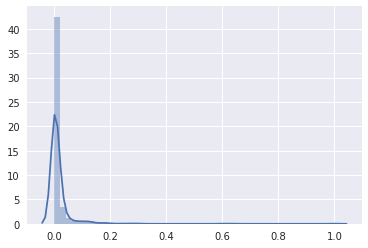

In [86]:
sns.distplot(nor(hot_y_l))

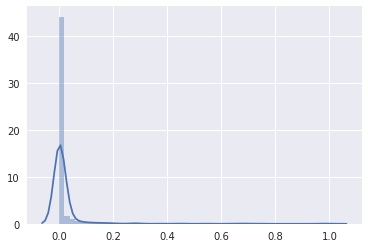

In [88]:
sns.distplot(nor(hot_3M_l))

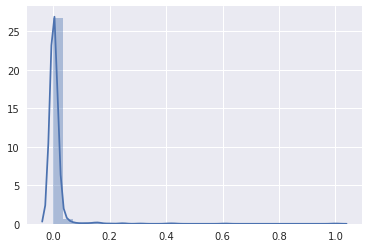

In [87]:
sns.distplot(nor(hot_1M_l))

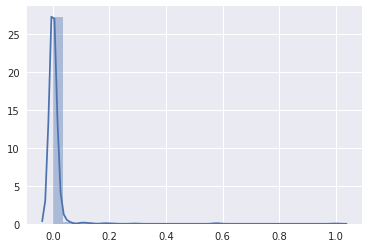

In [89]:
sns.distplot(nor(hot_lw_l))

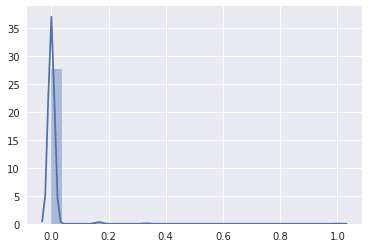

In [90]:
sns.distplot(nor(hot_ld_l))

In [132]:
b = search_term("飛越奇蹟")

In [133]:
len(b)

9

In [134]:
b = search_term("白宮第一管家")

In [135]:
len(b)

18

In [138]:
noerror_imdb_yahoomovie

{'\xe6\x84\x9b\xe7\x9a\x84\xe6\x8a\xb1\xe6\x8a\xb1': '6.2',
 '\xe8\x90\xac\xe6\x83\xa1\xe5\xa4\x9c\xe7\xb8\xbd\xe6\x9c\x83': '6.9',
 '\xe5\xb7\xb4\xe9\xbb\x8e\xe4\xb8\x8d\xe6\x89\x93\xe7\x83\x8a': '6.8',
 '\xe9\x96\x8b\xe9\xba\xa5\xe6\x8b\x89\xe9\xa9\x9a\xe9\xad\x82': '7.0',
 '\xe8\x91\xa1\xe8\x90\x84\xe7\x9a\x84\xe7\x9c\xbc\xe6\xb7\x9a': '5.9',
 '\xe7\xbe\x85\xe4\xb8\xb9\xe8\x96\xa9\xe7\x9a\x84\xe5\xa4\x9c\xe6\x99\x9a': '6.0',
 '\xe6\xb0\xb4\xe7\x94\xb7\xe9\xaa\xb8': '6.0',
 '\xe7\xac\xac\xe5\x9b\x9b\xe8\x80\x85': '6.3',
 '\xe7\x8c\xa9\xe7\x90\x83\xe5\xb4\x9b\xe8\xb5\xb7': '7.6',
 '\xe9\xa1\x9b\xe5\x80\x92\xe4\xb8\x96\xe7\x95\x8c': '6.4',
 '\xe7\x9c\x9f\xe6\x84\x9b\xe5\x9b\xa7\xe5\x86\xa4\xe5\xae\xb6': '5.6',
 '\xe5\xb7\xa7\xe5\x85\x8b\xe5\x8a\x9b\xe6\x83\x85\xe7\xb7\xa3': '8.2',
 '300\xe5\xa3\xaf\xe5\xa3\xab\xef\xbc\x9a\xe5\xb8\x9d\xe5\x9c\x8b\xe5\xb4\x9b\xe8\xb5\xb7': '6.2',
 '\xe8\xa7\xb8\xe4\xb8\x8d\xe5\x88\xb0\xe7\x9a\x84\xe6\x84\x9b\xe6\x88\x80': '6.8',
 'STAR WARS\xef\xbc\x9a\x